In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Customer_Churn.xlsx to Customer_Churn.xlsx


Baseline accuracy: 50.74%


<ipython-input-3-8c9b0e2d4406>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


DT best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10}
KNN best params: {'n_neighbors': 9, 'weights': 'uniform'}

Decision Tree → Acc: 69.67%, AUC: 0.764
              precision    recall  f1-score   support

        STAY       0.76      0.59      0.67      3044
       LEAVE       0.66      0.80      0.72      2956

    accuracy                           0.70      6000
   macro avg       0.71      0.70      0.69      6000
weighted avg       0.71      0.70      0.69      6000


KNN → Acc: 59.35%, AUC: 0.628
              precision    recall  f1-score   support

        STAY       0.61      0.56      0.58      3044
       LEAVE       0.58      0.63      0.60      2956

    accuracy                           0.59      6000
   macro avg       0.59      0.59      0.59      6000
weighted avg       0.59      0.59      0.59      6000



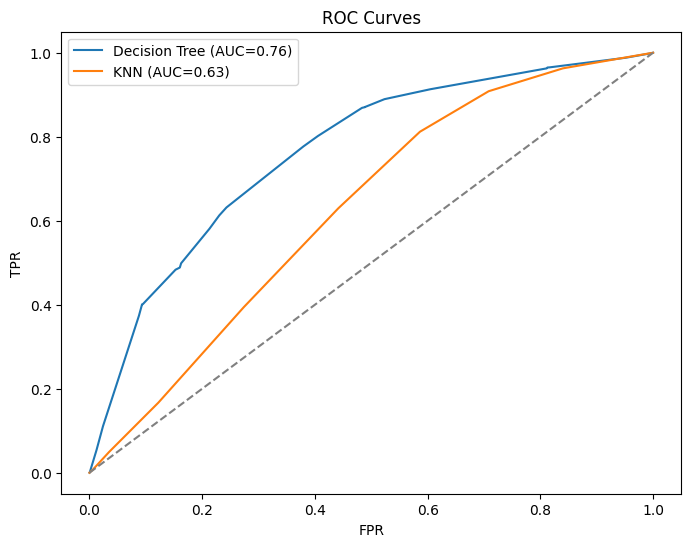

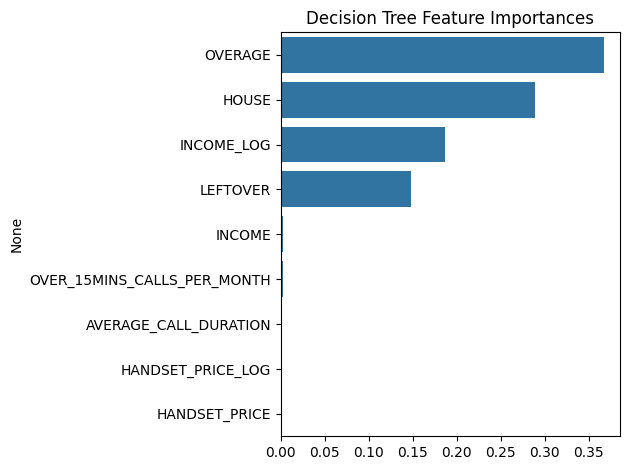


Class distribution:
LEAVE_FLAG
0    0.5074
1    0.4926
Name: proportion, dtype: float64

Top feature‑churn correlations:
OVERAGE                        0.235139
HOUSE                          0.211213
OVER_15MINS_CALLS_PER_MONTH    0.202193
INCOME                         0.096320
HANDSET_PRICE                  0.089221
HANDSET_PRICE_LOG              0.085110
INCOME_LOG                     0.084916
LEFTOVER                       0.060540
AVERAGE_CALL_DURATION          0.008704
Name: LEAVE_FLAG, dtype: float64


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report



# Load/Clean the data
df = pd.read_excel("Customer_Churn.xlsx")
df.dropna(subset=["OVERAGE","LEFTOVER","HOUSE","HANDSET_PRICE"], inplace=True)
for col in df.select_dtypes(include=["float64","int64"]):
    df[col].fillna(df[col].median(), inplace=True)
df["LEAVE_FLAG"] = df["LEAVE"].map({"STAY":0,"LEAVE":1})
cats = ["COLLEGE","REPORTED_SATISFACTION","REPORTED_USAGE_LEVEL","CONSIDERING_CHANGE_OF_PLAN"]
df = pd.get_dummies(df, columns=[c for c in cats if c in df], drop_first=True)
for col in ["INCOME","HANDSET_PRICE"]:
    if col in df: df[f"{col}_LOG"]=np.log1p(df[col])



# Prepare features & split
X = df.select_dtypes(include=["float64","int64"]).drop("LEAVE_FLAG",axis=1)
y = df["LEAVE_FLAG"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
    )



# Baseline accuracy
baseline = max(y_train.mean(),1-y_train.mean())
print(f"Baseline accuracy: {baseline:.2%}")



# Create/format the Decision Tree
cv = StratifiedKFold(5, shuffle=True, random_state=42)
dt_params = {"max_depth":[3,5,7,None],"min_samples_split":[2,5,10],"class_weight":[None,"balanced"]}
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=cv, scoring="roc_auc", n_jobs=-1)
dt_gs.fit(X_train,y_train)
dt = dt_gs.best_estimator_
print("DT best params:", dt_gs.best_params_)



# Create/Format the KNN
knn_params = {"n_neighbors":[3,5,7,9],"weights":["uniform","distance"]}
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=cv, scoring="roc_auc", n_jobs=-1)
knn_gs.fit(X_train,y_train)
knn = knn_gs.best_estimator_
print("KNN best params:", knn_gs.best_params_)



# Evaluate DT and KNN plot ROC curves
plt.figure(figsize=(8,6))
for name, model in [("Decision Tree",dt),("KNN",knn)]:
    p = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test,p)
    auc = roc_auc_score(y_test,proba)
    print(f"\n{name} → Acc: {acc:.2%}, AUC: {auc:.3f}")
    print(classification_report(y_test,p,target_names=["STAY","LEAVE"]))
    fpr,tpr,_ = roc_curve(y_test,proba)
    plt.plot(fpr,tpr,label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()



# Show DT feature importances
imp = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=imp.values, y=imp.index)
plt.title("Decision Tree Feature Importances"); plt.tight_layout(); plt.show()



# Show class balance correlations
print("\nClass distribution:")
print(y.value_counts(normalize=True).rename("proportion"))
corrs = X.join(y).corr()["LEAVE_FLAG"].drop("LEAVE_FLAG").abs().sort_values(ascending=False)
print("\nTop feature‑churn correlations:")
print(corrs.head(10))

In [ ]:
#Data Understanding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# load the sheet
df = pd.read_excel("Customer_Churn.xlsx", sheet_name=0)

# normalize column names
df.columns = df.columns.str.strip()

# glimpse
print(df.info(), "\n")
print(df.describe(include="all").T)

# missing values
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   COLLEGE                      20000 non-null  object
 1   INCOME                       20000 non-null  int64 
 2   OVERAGE                      20000 non-null  int64 
 3   LEFTOVER                     20000 non-null  int64 
 4   HOUSE                        20000 non-null  int64 
 5   HANDSET_PRICE                20000 non-null  int64 
 6   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 7   AVERAGE_CALL_DURATION        20000 non-null  int64 
 8   REPORTED_SATISFACTION        20000 non-null  object
 9   REPORTED_USAGE_LEVEL         20000 non-null  object
 10  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 11  LEAVE                        20000 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB
None 

                               count

Normalized columns: ['college', 'income', 'overage', 'leftover', 'house', 'handset_price', 'over_15mins_calls_per_month', 'average_call_duration', 'reported_satisfaction', 'reported_usage_level', 'considering_change_of_plan', 'leave']


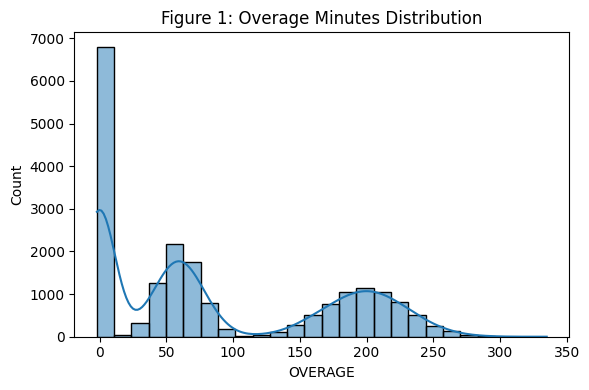

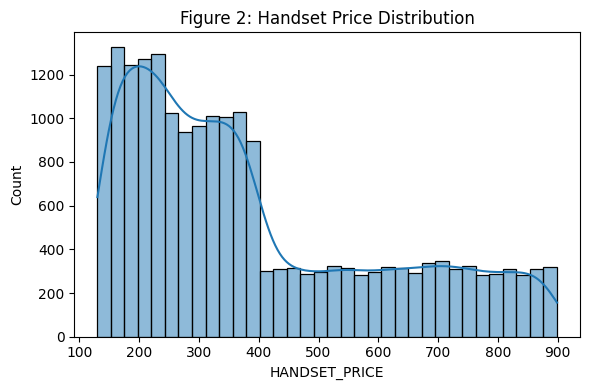

In [ ]:
df.columns = df.columns.str.strip().str.lower()
print("Normalized columns:", df.columns.tolist())

# Map churn to binary target
df["leave"] = df["leave"].map({"STAY": 0, "LEAVE": 1})

# 1b) Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of OVERAGE
plt.figure(figsize=(6,4))
sns.histplot(df["overage"], kde=True)
plt.title("Figure 1: Overage Minutes Distribution")
plt.xlabel("OVERAGE")
plt.tight_layout()
plt.show()

# Histogram of HANDSET_PRICE
plt.figure(figsize=(6,4))
sns.histplot(df["handset_price"], kde=True)
plt.title("Figure 2: Handset Price Distribution")
plt.xlabel("HANDSET_PRICE")
plt.tight_layout()
plt.show()

In [ ]:
#2 Predictive Modelling
df_enc = pd.get_dummies(df, columns=[
    'college', 'reported_satisfaction',
    'reported_usage_level', 'considering_change_of_plan'
], drop_first=True)
X = df_enc.drop('leave', axis=1)
y = df_enc['leave']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Baseline — MSE: {mse_lr:.3f}, R²: {r2_lr:.3f}")

Linear Regression Baseline — MSE: 0.220, R²: 0.118


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

models = {
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, m in models.items():
    cv_acc = cross_val_score(m, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    cv_auc = cross_val_score(m, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    results[name] = {'cv_accuracy': cv_acc, 'cv_auc': cv_auc}
print(pd.DataFrame(results).T)

                    cv_accuracy    cv_auc
KNN                    0.581714  0.618462
LogisticRegression     0.639143  0.692714
DecisionTree           0.694429  0.760586
MLPClassifier          0.528500  0.573325


KNN             | Test Acc: 0.592 | Test AUC: 0.623
LogisticRegression | Test Acc: 0.642 | Test AUC: 0.697
DecisionTree    | Test Acc: 0.697 | Test AUC: 0.765
MLPClassifier   | Test Acc: 0.646 | Test AUC: 0.693


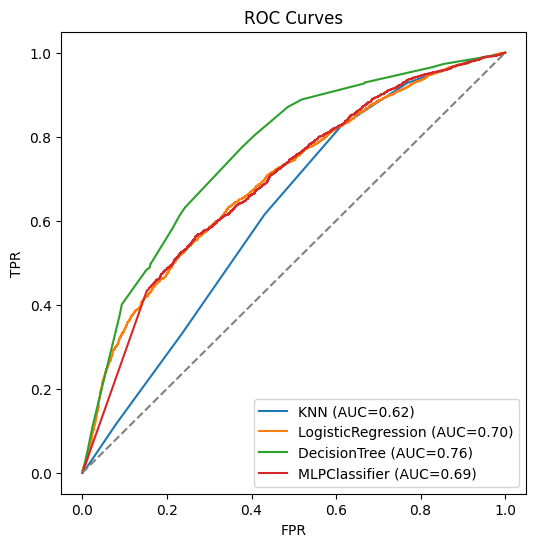

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
plt.figure(figsize=(6,6))
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    print(f"{name:15s} | Test Acc: {acc:.3f} | Test AUC: {auc:.3f}")
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [ ]:
# 4 Data Balance
y_counts = y.value_counts(normalize=True)
print('Class distribution:', y_counts.to_dict())
print('Naïve baseline:', y_counts.max())

Class distribution: {0: 0.5074, 1: 0.4926}
Naïve baseline: 0.5074


In [ ]:
#6 Correlations
import pandas as pd
from IPython.display import display

# Extract logistic regression coefficients and tree importances
logit = models['LogisticRegression']
coef_series = pd.Series(logit.named_steps['logisticregression'].__dict__.get('coef_', logit.coef_)[0]
                            if hasattr(logit, 'named_steps') else logit.coef_[0],
                           index=X.columns)
coef_series = coef_series.sort_values(ascending=False)

tree = models['DecisionTree']
imp_series = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

# Prepare DataFrames of top features
coef_df = coef_series.head(10).rename('logistic_coef').reset_index().rename(columns={'index':'feature'})
imp_df = imp_series.head(10).rename('tree_importance').reset_index().rename(columns={'index':'feature'})

top_features = pd.merge(coef_df, imp_df, on='feature', how='outer').fillna('-')

print("Top Features by Model Importance")
display(top_features)

Top Features by Model Importance


,feature,logistic_coef,tree_importance
0,average_call_duration,0.019496,0.001669
1,college_zero,-,0.001335
2,considering_change_of_plan_considering,-,0.001153
3,considering_change_of_plan_no,0.002451,-
4,considering_change_of_plan_perhaps,0.003139,-
5,handset_price,0.000456,0.002509
6,house,-,0.290369
7,income,-,0.188062
8,leftover,0.006768,0.1463
9,over_15mins_calls_per_month,0.014242,0.001174
